In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

In [3]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [5]:
import re
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv("C:\\Users\\saina\\Downloads\\archive (8)\\AI_Human.csv")
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [7]:
ai_samples = data[data['generated']==1]
human_samples = data[data['generated']==0]
print(ai_samples.shape, human_samples.shape)

(181438, 2) (305797, 2)


In [8]:
data = pd.concat([ai_samples.sample(n=5000, random_state=42), human_samples.sample(n=5000, random_state=42)])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 279451 to 156499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       10000 non-null  object 
 1   generated  10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [9]:
data['generated'].value_counts()

generated
1.0    5000
0.0    5000
Name: count, dtype: int64

In [10]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,text,generated
0,"Dear Principal,\n\nWe have been hearing quite ...",0.0
1,"Dear [State Senator],\n\nI am writing to expr...",1.0
2,"As high school students, we are constantly bom...",1.0
3,"Hi, I'm a 6th garden and I think zoos ANE Near...",1.0
4,"Sure, jar's my attempt at writing an essay as ...",1.0


In [11]:
def tokenize(text): # tokenize text into words
    ans = word_tokenize(text)
    return ans

def remove_punc(text): # remove punctuations from the text
    ans = [word for word in text if word not in punctuation]
    return " ".join(ans)
    
def remove_stop(text): # remove stopwords from the text
    stops = set(stopwords.words('english'))
    ans = " ".join([word for word in text.split() if word not in stops])
    return ans

def remove_links(text): # remove links from the text
    return re.sub(r'https?:\/\/(.[\r\n])', '', text, flags=re.MULTILINE)

def remove_tags(text): # remove html tags
    pattern = re.compile(r'<.*?>')   
    return pattern.sub('', text)

def again(text): # reverse tokenization
    ans = " ".join([word for word in text])
    return ans

def count_punc(text): # return count of characters in the text
    count = sum([1 for char in text if char in punctuation])
    return count

def has_tags(text):
    pattern = re.compile(r'<.*?>')
    match = re.search(pattern, text)
    return match is not None

def count_stop(text):
    stops = set(stopwords.words('english'))
    count = sum(1 for word in text if word in stops)
    return count

In [12]:
data['text'].apply(has_tags).sum()

6

In [13]:
data['text'].apply(count_punc).sum()

476395

In [14]:
data['text'].apply(count_stop).sum()

8178665

In [15]:
data['cleaned'] = data['text'].str.lower()
data.head()

,text,generated,cleaned
0,"Dear Principal,\n\nWe have been hearing quite ...",0.0,"dear principal,\n\nwe have been hearing quite ..."
1,"Dear [State Senator],\n\nI am writing to expr...",1.0,"dear [state senator],\n\ni am writing to expr..."
2,"As high school students, we are constantly bom...",1.0,"as high school students, we are constantly bom..."
3,"Hi, I'm a 6th garden and I think zoos ANE Near...",1.0,"hi, i'm a 6th garden and i think zoos ane near..."
4,"Sure, jar's my attempt at writing an essay as ...",1.0,"sure, jar's my attempt at writing an essay as ..."


In [16]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_links(x))
data['cleaned'].head()

0    dear principal,\n\nwe have been hearing quite ...
1     dear [state senator],\n\ni am writing to expr...
2    as high school students, we are constantly bom...
3    hi, i'm a 6th garden and i think zoos ane near...
4    sure, jar's my attempt at writing an essay as ...
Name: cleaned, dtype: object

In [17]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_tags(x))
data['cleaned'].head()

0    dear principal,\n\nwe have been hearing quite ...
1     dear [state senator],\n\ni am writing to expr...
2    as high school students, we are constantly bom...
3    hi, i'm a 6th garden and i think zoos ane near...
4    sure, jar's my attempt at writing an essay as ...
Name: cleaned, dtype: object

In [18]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_stop(x))
data['cleaned'].head()

0    dear principal, hearing quite lot subject comm...
1    dear [state senator], writing express opinion ...
2    high school students, constantly bombarded inf...
3    hi, i'm 6th garden think zoos ane nearly cool!...
4    sure, jar's attempt writing essay average 8tj ...
Name: cleaned, dtype: object

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
data['cleaned'] = data['cleaned'].apply(lambda x: tokenize(x))
data['cleaned'].head()

0    [dear, principal, ,, hearing, quite, lot, subj...
1    [dear, [, state, senator, ], ,, writing, expre...
2    [high, school, students, ,, constantly, bombar...
3    [hi, ,, i, 'm, 6th, garden, think, zoos, ane, ...
4    [sure, ,, jar, 's, attempt, writing, essay, av...
Name: cleaned, dtype: object

In [21]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_punc(x))
data['cleaned']

0       dear principal hearing quite lot subject commu...
1       dear state senator writing express opinion ele...
2       high school students constantly bombarded info...
3       hi i 'm 6th garden think zoos ane nearly cool ...
4       sure jar 's attempt writing essay average 8tj ...
                              ...                        
9995    good actions helpful ways good altered led goo...
9996    article `` unmaking face mars '' explains face...
9997    driving extremely dangerous anyone else especi...
9998    hey there so know people say `` kindness goes ...
9999    agree driveless cars their 's lot things go wr...
Name: cleaned, Length: 10000, dtype: object

In [39]:
!pip install keras tensorflow

In [22]:
from tensorflow import keras

tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(data['cleaned'])

data['text_sequences'] = tokenizer.texts_to_sequences(data['cleaned'])

In [23]:
(data['text_sequences'].apply(lambda x: len(x))).max()

879

In [24]:
from keras.preprocessing.sequence import pad_sequences

input_shape=int(data['text_sequences'].apply(len).mean())

X=pad_sequences(data['text_sequences'],maxlen=input_shape)

In [43]:
X[0].shape

(212,)

In [25]:
y=data['generated']

In [26]:
from sklearn.preprocessing import LabelEncoder
LB=LabelEncoder()
y=LB.fit_transform(y)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100) 
print("X_train : \n",X_train)
print("X_test  : \n",X_test)

X_train : 
 [[   0    0    0 ...  508  607  152]
 [1608  131  422 ...  508 1253  152]
 [   0    0    0 ...  109  487  336]
 ...
 [   5  265 1112 ... 1654   49  508]
 [   0    0    0 ... 1138  141  190]
 [   0    0    0 ...  166  639    1]]
X_test  : 
 [[   9  504 5856 ...  508  607  152]
 [   0    0    0 ... 1391   75  178]
 [   0    0    0 ...  381  765  935]
 ...
 [  20  110   54 ...   11  349 1756]
 [   0    0    0 ...   89  102  138]
 [1737  143   28 ...    1  186  586]]


In [28]:
print("X_train shape : ",X_train.shape)
print("X_test  shape : ",X_test.shape)

X_train shape :  (8000, 212)
X_test  shape :  (2000, 212)


In [29]:
Max_words=int((max(map(max, X)))+1)
Max_words

37209

In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import BatchNormalization

embedding_size = 100

model = Sequential()
model.add(Embedding(Max_words, embedding_size, mask_zero=True, input_length=input_shape))

model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next LSTM layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

model.add(Dense(2, activation='softmax'))  # For classification

model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.7763 - loss: 0.4160 - val_accuracy: 0.9581 - val_loss: 0.1654
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.9630 - loss: 0.1324 - val_accuracy: 0.9500 - val_loss: 0.1597
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9860 - loss: 0.0570 - val_accuracy: 0.9544 - val_loss: 0.2057
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.9940 - loss: 0.0304 - val_accuracy: 0.9625 - val_loss: 0.1412
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.9475 - loss: 0.1729 - val_accuracy: 0.9588 - val_loss: 0.1736
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.8890 - loss: 0.2124 - val_accuracy: 0.9337 - val_loss: 0.2832
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9661 - loss: 0.1106 - val_accuracy: 0.9581 - val_loss: 0.1639
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.9856 - loss: 0.0486 - val_accu

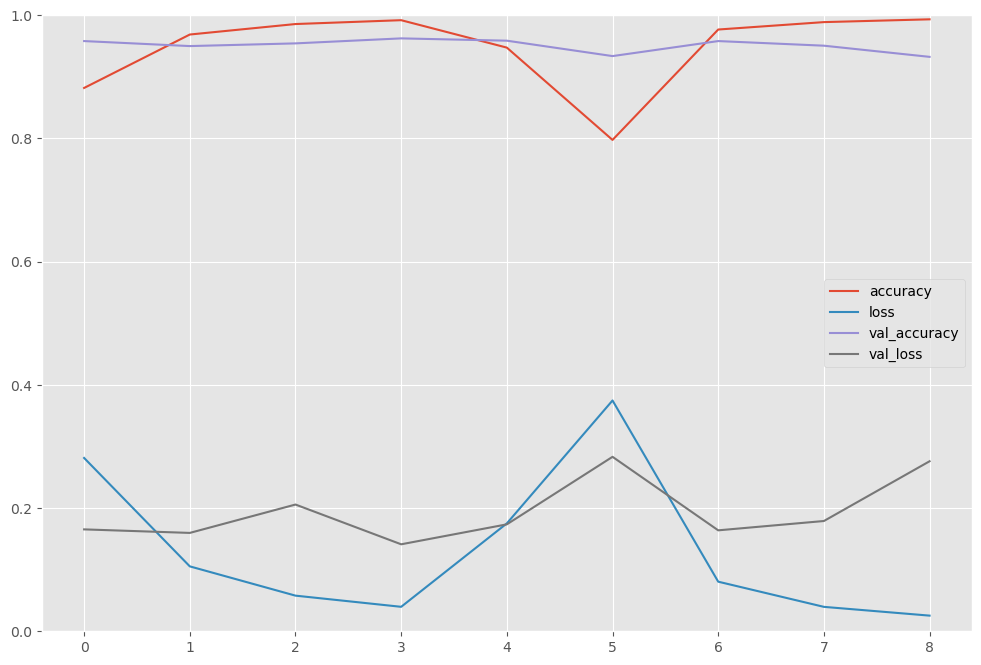

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 332ms/step - accuracy: 0.9633 - loss: 0.1394
Loss     :  0.15224947035312653
accuracy :  0.9595000147819519


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 302ms/step
Classification report : 
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1003
         1.0       0.96      0.96      0.96       997

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

Confusion matrix : 



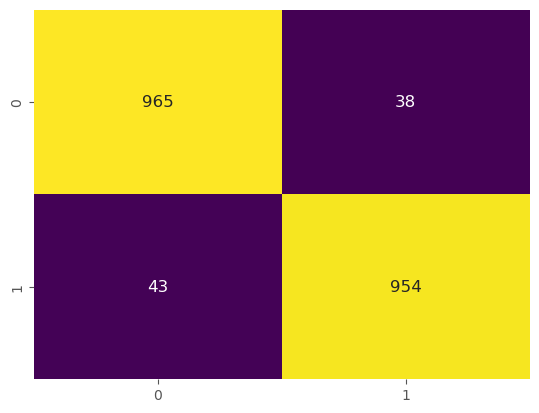

Normalized confusion matrix : 



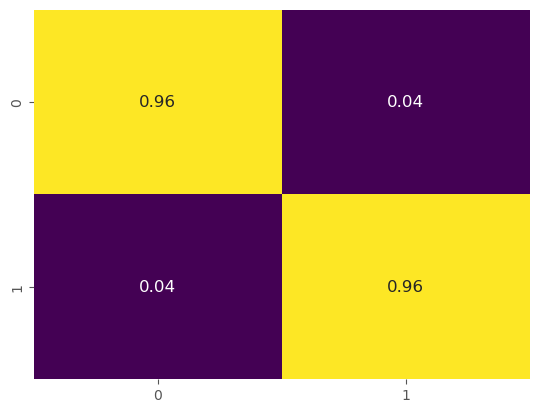

In [52]:
y_pred = (model.predict(X_test).argmax(axis=-1)).tolist()

class_names = [str(name) for name in LB.classes_]

from sklearn.metrics import classification_report, confusion_matrix
print("Classification report : \n",classification_report(y_test, y_pred, target_names = class_names))

import seaborn as sns
def draw_confusion_matrix(true, preds, normalize=None):
  conf_matx = confusion_matrix(true, preds, normalize = normalize)
  conf_matx = np.round(conf_matx, 2)

  sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12},fmt="g", cbar=False, cmap="viridis")
  plt.show()
    
print("Confusion matrix : \n")
draw_confusion_matrix(y_test, y_pred)

print("Normalized confusion matrix : \n")
draw_confusion_matrix(y_test, y_pred,"true")

In [34]:
import gensim.downloader as api

# Load pretrained FastText model
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

# Convert words to vectors
def fasttext_embedding(text):
    vectors = [fasttext_model[word] for word in text if word in fasttext_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)  # Handle empty case


# Apply embedding transformation
data['fasttext_embedding'] = data['cleaned'].apply(fasttext_embedding)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(300,)))  # FastText vectors are 300-dim
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,914 (183.26 KB)

 Trainable params: 46,914 (183.26 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Convert X_train and X_test back to their original indices before using them
X_train_indices, X_test_indices, y_train, y_test = train_test_split(
    data.index, y, test_size=0.20, random_state=100
)

# Convert to FastText embeddings using iloc
X_train = np.vstack(data.iloc[X_train_indices]['fasttext_embedding'].values)
X_test = np.vstack(data.iloc[X_test_indices]['fasttext_embedding'].values)


In [40]:
# Reinitialize and recompile the model before training
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(300,)))  # 300-dimensional FastText
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train again
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5145 - loss: 0.6950 - val_accuracy: 0.5994 - val_loss: 0.6785
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5934 - loss: 0.6693 - val_accuracy: 0.6031 - val_loss: 0.6303
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6736 - loss: 0.6077 - val_accuracy: 0.7044 - val_loss: 0.5678
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 0.5752 - val_accuracy: 0.7287 - val_loss: 0.5468
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7212 - loss: 0.5547 - val_accuracy: 0.7319 - val_loss: 0.5361
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7303 - loss: 0.5435 - val_accuracy: 0.7113 - val_loss: 0.5574
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7304 - loss: 0.5425 - val_accuracy: 0.6819 - val_loss: 0.5916
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7313 - loss: 0.5382 - val_accuracy: 0.

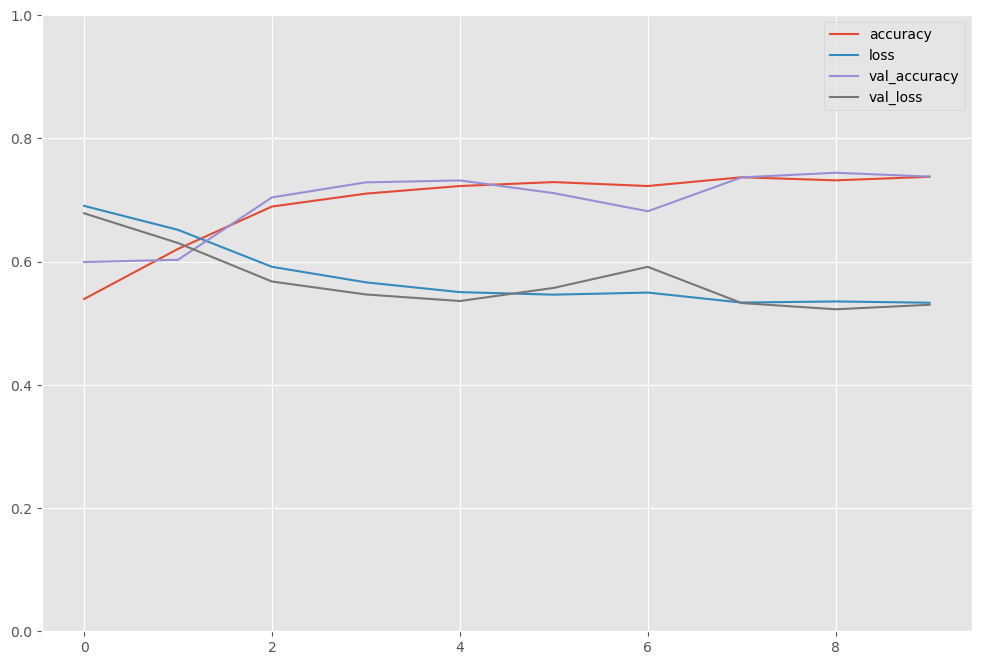

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7232 - loss: 0.5427
Loss     :  0.5343707203865051
accuracy :  0.7289999723434448


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

In [46]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [27]:
conda install torchvision -c pytorch -y

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 25.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.3.0




In [25]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [39]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

def compute_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    loss = model(**inputs, labels=inputs["input_ids"]).loss
    return torch.exp(loss).item()  # Perplexity score

data['perplexity'] = data['text'].apply(compute_perplexity)

RuntimeError: Failed to import transformers.models.gpt2.modeling_gpt2 because of the following error (look up to see its traceback):
No module named 'torchvision.transforms'

In [36]:
!pip uninstall torchvision -y
!pip install torchvision

Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Successfully uninstalled torchvision-0.17.2
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/88/53/4ad334b9b1d8dd99836869fec139cb74a27781298360b91b9506c53f1d10/torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torch==2.6.0 from https://files.pythonhosted.org/packages/11/c5/2370d96b31eb1841c3a0883a492c15278a6718ccad61bb6a649c80d1d9eb/torch-2.6.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.6.0-cp311-cp311-win_amd64.whl.metadata (28 kB)
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.6 MB 544.7 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.6 MB 1.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.6 MB 1.1 MB/s eta 0:00:02
   ----

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\saina\\anaconda3\\Lib\\site-packages\\~0rch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [34]:
import torchvision
print(torchvision.__version__)

AttributeError: module 'torchvision' has no attribute '__version__'

In [37]:
pip install --user torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/88/53/4ad334b9b1d8dd99836869fec139cb74a27781298360b91b9506c53f1d10/torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
Using cached torchvision-0.21.0-cp311-cp311-win_amd64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.
